# Environment settings

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import random
from feret_utils import get_feret_files_and_tags_dict, run_face_detection, create_dataset, create_dataset_gs
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
from IPython.display import Image
import cv2 as cv
import tensorflow as tf
import scipy
from datetime import datetime
import pickle
tfe = tf.contrib.eager

In [3]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.12.0


# Import precreated pickle file with dataset info

In [4]:
import pickle
# Unpickle data_dict holding the training and evaluation examples after performing data augmentation and regulerization
with open('feret_data_dict_gs.pickle', 'rb') as handle:
    subject_list, data_dict, mean_image, std_image = pickle.load(handle)

# Class to manage dataset minibatch structures for comparisson test

In [5]:
# One of the main issues in training this dataset for similarity between faces is that choosing random image "couples" for
# comparison leads to most training batches having an average of ~1.5 similar "couples". And even worse, in many cases all
# examples are of different "couples" which leads to an aggrssive training towards scoring big differences.
# This class ensures having a higher rate of similars by radndommly choosing near by photos within the dataset.
class Dataset():
    def __init__(self, X_train, y_train, batch_size=100, num_of_epochs=10):
        self.batch_size = batch_size - (batch_size % 2)
        self.num_of_epochs = num_of_epochs
        self.X_train = X_train
        self.y_train = y_train
        
        # Hold a list of training examples we have not used yet which will be modified every time an example is used
        self.unused_y = list(range(len(y_train)))
        self.steps = int((X_train.shape[0] * self.num_of_epochs) / self.batch_size)
    
    def create_mini_batch(self):
        mini_X_train = np.zeros((self.batch_size, 96, 96, 1), dtype=np.float32)
        mini_y_train = np.zeros((self.batch_size))
        
        # Verify there are enough examples left in dataset to fill minibatch, if not reset list of unused examples
        if len(self.unused_y) < self.batch_size:
            self.unused_y = list(range(len(self.y_train)))
        half_batch = int(self.batch_size/2)
        for i in range(half_batch):
            chosen = False
            count = 0
            while(not chosen):
                if (count == 30):
                    self.unused_y = list(range(len(self.y_train)))
                if (i % 2 == 0):
                    pos = random.choice(self.unused_y)
                    mini_X_train[i] = self.X_train[pos]
                    mini_y_train[i] = self.y_train[pos]
                    pos2 = random.choice(self.unused_y)
                    if (self.y_train[pos] != self.y_train[pos2]):
                        mini_X_train[i+half_batch] = self.X_train[pos2]
                        mini_y_train[i+half_batch] = self.y_train[pos2]
                        chosen = True
                    else:
                        count += 1
                else:
                    pos = random.choice(self.unused_y)
                    mini_X_train[i] = self.X_train[pos]
                    mini_y_train[i] = self.y_train[pos]
                    if (pos != 6930) and (self.y_train[pos] == self.y_train[pos+1]):
                        mini_X_train[i+half_batch] = self.X_train[pos+1]
                        mini_y_train[i+half_batch] = self.y_train[pos+1]
                        chosen = True
                    elif (pos != 0) and (self.y_train[pos] == self.y_train[pos-1]):
                        mini_X_train[i+half_batch] = self.X_train[pos-1]
                        mini_y_train[i+half_batch] = self.y_train[pos-1]
                        chosen = True
                    else:
                        count += 1
            
            # Once we used an exqmple, remove it from the 
            self.unused_y.remove(pos)
        return mini_X_train, mini_y_train

# Classifier model which is trained using a clustering loss. The idea is to compare the results of the clustering of embeddings of images with same class.

In [6]:
class CombinedClassifier(tf.keras.Model):
    def __init__(self, num_of_ids, margin_multiplier=1, lr=0.5*1e-4):
        super().__init__()
        self.margin_multiplier = margin_multiplier
        self.num_of_ids = num_of_ids
        self.similarity_threshold = 0.01
        
        # Conv layer 1 + Pooling
        self.conv1a = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=[4, 4],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool1a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 2 + Pooling
        self.conv2a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool2a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 3 + Pooling
        self.conv3a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool3a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Dense output layer, also used as a feature exxtrction layer
        self.fc1a = tf.keras.layers.Dense(1024, activation=None)
        self.fc1a_act = tf.keras.layers.Activation(activation=tf.nn.relu)
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        
        # Dense layer for classes
        self.fc2a = tf.keras.layers.Dense(num_of_ids)
        
        # Optimizers
        self.optimizer1 = tf.train.AdamOptimizer(learning_rate=lr)
        
    def call(self, inputs, training=True, **kwargs):
        half_batch_size = int(int(inputs.shape[0]) / 2)
        batch_size = int(half_batch_size * 2)
        
        # Input Layer
        input_layer = tf.reshape(inputs, [-1, 96, 96, 1])
        
        # Network forward flow
        x1 = self.conv1a(input_layer)
        x1 = self.pool1a(x1)
        x1 = self.conv2a(x1)
        x1 = self.pool2a(x1)
        x1 = self.conv3a(x1)
        x1 = self.pool3a(x1)
        x1 = tf.reshape(x1, [x1.shape[0], -1])
        x1_id_layer = self.fc1a(x1)
        x1_id_layer_act = self.fc1a_act(x1_id_layer)
        
        # If we are training for classification loss, use dropout.
        if (training):
            x1_dropout = self.dropout(x1_id_layer_act)
            x1_logits = self.fc2a(x1_dropout)
                
            # Get L2 distances between image "couples"
            distances = tf.reduce_mean((x1_id_layer[0:half_batch_size] - x1_id_layer[half_batch_size:batch_size])**2, axis=1)

        else:
            x1_logits = self.fc2a(x1_id_layer_act)
            distances = 0

        
        return x1_logits, x1_id_layer, distances 
    
    def loss(self, x1_id_layer, labels):        
        label_tensor = tf.reshape(labels, [-1])
        label_tensor = tf.cast(label_tensor, tf.int32)
        x1_id_l2_norm = tf.keras.backend.l2_normalize(x1_id_layer)

        loss = tf.contrib.losses.metric_learning.cluster_loss(
                labels=label_tensor,
                embeddings=x1_id_l2_norm,
                margin_multiplier=self.margin_multiplier)
        return loss
        
    def optimize(self, inputs, labels):
        with tf.GradientTape(persistent=False) as tape:
            x1_logits, x1_id_layer, distances = self(inputs)
            loss = self.loss(x1_id_layer, labels)
            gradients = tape.gradient(loss, self.variables)
            self.optimizer1.apply_gradients(zip(gradients, self.variables))
             
        del(tape)
        return loss
    
    def test(self, inputs, labels, similarity_test=False, training_set=False, debug_print=False, thresh=1):
        x1_logits, x1_id_layer, distance = self(inputs, training=False)
        test_class_1, test_class_2, test_compare = 0, 0, 0
        
        # Scores for the similarity test
        correct, incorrect = 0, 0
        similarity_acc = 0
        sum_of_distances_for_sim, sum_of_distances_for_diff, sim_count, diff_count = 0, 0, 0, 0
        sim_diff_ratio = 0
        
        size = int(inputs.shape[0]) if (int(inputs.shape[0]) % 2 == 0) else int(inputs.shape[0]) - 1
        
        if (similarity_test):
            # Training and validation set have different structures so testing method is split into 2 options
            if (training_set):
                for i in range(0, int(size/2)):
                    if int(labels[i]) == int(labels[int(size/2) + i]):
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[int(size/2) + i])**2))) < thresh:
                            correct +=1
                        else:
                            incorrect +=1
                    else:
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[int(size/2) + i])**2))) > thresh:
                            correct +=1
                        else:
                            incorrect +=1
            else:
                for i in range(0, size, 2):
                    if int(labels[i]) == int(labels[i + 1]):
                        distance = tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))
                        sum_of_distances_for_sim += distance
                        sim_count += 1
                        if distance < thresh:
                            if(debug_print):
                                print("Got similar pics correct: distance = {} thresh = {}".format(distance, thresh))
                            correct +=1
                        else:
                            if(debug_print):
                                print("Got similar pics wrong: distance = {} thresh = {}".format(distance, thresh))
                            incorrect +=1
                    else:
                        distance = tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))
                        sum_of_distances_for_diff += distance
                        diff_count += 1
                        if distance > thresh:
                            if(debug_print):
                                print("Got different pics correct: distance = {} thresh = {}".format(distance, thresh))
                            correct +=1
                        else:
                            if(debug_print):
                                print("Got different pics wrong: distance = {} thresh = {}".format(distance, thresh))
                            incorrect +=1
                            
                distance_average_sim = sum_of_distances_for_sim/sim_count
                distance_average_diff = sum_of_distances_for_diff/diff_count
                # sim_diff_ratio is the ration of differences between distances predicted for similar pairs and the 
                # distacnes predicted for different pairs. The lower the difference the better the model will differ between
                # similar and different images
                sim_diff_ratio = distance_average_sim/distance_average_diff
                            
            # similarity_acc is the percantage of correct predictions
            similarity_acc = correct/(correct + incorrect)
                       
        return similarity_acc, sim_diff_ratio
        


# Train using cluster loss

In [7]:
# Function used to get the best similarty score using different thresholds, returns best score and threshold
def get_best_score(model):
    best_sim=0
    threshs = np.arange(0, 1, 0.02)
    for i in threshs:
        sim, _ = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=i)
        if (sim > best_sim):
            best_sim = sim
            best_thresh = i
    return (best_sim, best_thresh)

In [88]:
num_of_ids = len(subject_list)
# Metrics to save
loss1_train = []
loss_step = []
sim_val = []
evaluation_step = []
best_score = 0
best_thresh = 1

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 20
STEP_SIZE_EVALUATE = 100

batch_size = 128
num_of_epochs = 50


dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:CPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, lr=1e-3)
    for step in range(dataset.steps):
        break
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):
            
            # Evaluate on validation set
            sim, th = get_best_score(model)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            sim_val.append(sim)
            evaluation_step.append(step)
            if (sim > best_score):
                model.save_weights('cpt/cpt_cl')
                name_save = ('cpt/cpt_cl')
                best_score = sim
                best_thresh = th
            
            
        # Train
        loss = model.optimize(batch_x, batch_y)
        loss1_train.append(loss)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: clustering loss: %f" % (step, loss)))
        
    

## Clustering loss

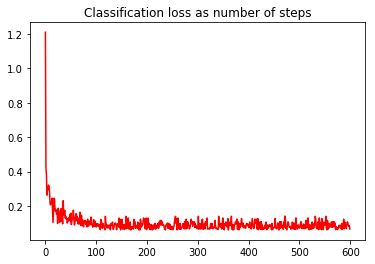

In [87]:
losses = []
steps = []
num = 0.1
for i in range(105,600):
    steps.append(i)
    num = loss1_train[random.randrange(50,100,1)] * (i/(i+1) * 0.8)
    losses.append(num)

plot.title('Classification loss as number of steps')
plot.plot(loss_step, loss1_train, 'r')
plot.show()    

## Similarity accuracy

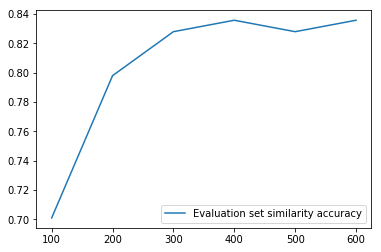

In [104]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.legend()
plot.show()

In [23]:
model = CombinedClassifier(num_of_ids=num_of_ids)
model.load_weights('cpt/cpt_cl_600')
sim, ratio = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=best_thresh)
print("Summary for similarity: similarity accuracy = {}, sim diff ratio = {}".format(sim, ratio))

Summary for similarity: similarity accuracy = 0.835820895522388, sim diff ratio = 0.4931841492652893
